<a href="https://colab.research.google.com/github/ZhongyuZhao/Coursera_Capstone/blob/main/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - The Battle of the Neighborhoods




 **Zhongyu Zhao**

 **Feb, 2021**

## Introduction

Lots of people are migrating to Canada. There's no doubt that they need to do a lot of research for good housing prices and living enviroments. This project is for those people who are looking for better neighborhoods. Precisely speaking, this project focus on those who wants to move to North York and willing to find a neighborhood that meets his demand.

In this project we will try to find an optimal location in North York for Torontonians to move in. Specifically, this report will be targeted to find a safe and convenient neighborhood that is similar to the previous one.

Since there are lots of neighborhoods in North York we will try to do clustering to filter out some of them. We will also use crime rate data and traffic data to secure the safety and convenience of the neighborhood. We would prefer neighborhood as safe as possible. We also want the neighborhood could offer venues that users love and not too far from the public transit.

## Data Description



Data Link:

https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

https://en.wikipedia.org/wiki/List_of_Toronto_subway_stations

https://www.kaggle.com/alincijov/toronto-crime-rate-per-neighbourhood

Will use the data scrapped from wikipedia on Week 3. I will use Toronto venues data ,neighborhood crime data and traffic data to finish my project.

### Foursquare API Data

We will need data about different venues in different neighborhoods of that specific borough. In order to gain that information we will use "Foursquare" locational information. Foursquare is a location data provider with information about all manner of venues and events within an area of interest. Such information includes venue names, locations, menus and even photos. As such, the foursquare location platform will be used as the sole data source since all the stated required information can be obtained through the API.

After finding the list of neighborhoods, we then connect to the Foursquare API to gather information about venues inside each and every neighborhood. For each neighborhood, we have chosen the radius to be 100 meter.

The data retrieved from Foursquare will contain information of venues in North York and Downtown Toronto. The information obtained per venue as follows:

1.Neighborhood

2.Neighborhood Latitude

3.Neighborhood Longitude

4.Venue 

5.Name of the venue

6.Venue Latitude 

7.Venue Longitude 

8.Venue Category 

We will use these data to find a kind of correspondence between downtown neighborhoods and North York neighborhoods.

### 2.2.Toronto Crime Data

In order to select the best neighborhood, We will use crime rate data to find out if a neighborhood is safe enough. We will focus on different kinds of crime rating for each neighborhood and rank them.

The data retrieved from Toronto Crime Data will contain information of crime rates in Toronto. The information obtained follows:

1.Neighborhood

2.Assault Rate

3.Autotheft Rate

4.BreakandEnter Rate

5.Homicide Rate

6.Robbery Rate

7.Theftover Rate

Note: These rates are calculated based on data collected in 2019.

### Toronto Subway Station Data

It's scraped from wikipedia, showing all the subway stations' name in Toronto.The information obtained as follows:

1.Station

## Methodology

We start off by importing all the required packages.

In [ ]:
import pandas as pd
import numpy as np
import requests
from geopy.geocoders import Nominatim
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.distance import geodesic

Package breakdown:

Pandas : To collect and manipulate data and do data analysis

requests : Handle http requests and scrap data

matplotlib : Plot maps for data visualization

folium : Generating maps

sklearn : Import K-means algorithm

geopy: Calculate distance between two place

## Data Collection

We use requests to scrap neighborhoods' data from wikipedia and store those data in pandas dataframe. 

The data looks like this:




,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


We collect crime rate data from Kaggle.
Here is the data:

In [ ]:
crime_rate.head()

,OBJECTID,Neighbourhood,Hood_ID,Population,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,Assault_AVG,Assault_CHG,Assault_Rate_2019,AutoTheft_2014,AutoTheft_2015,AutoTheft_2016,AutoTheft_2017,AutoTheft_2018,AutoTheft_2019,AutoTheft_AVG,AutoTheft_CHG,AutoTheft_Rate_2019,BreakandEnter_2014,BreakandEnter_2015,BreakandEnter_2016,BreakandEnter_2017,BreakandEnter_2018,BreakandEnter_2019,BreakandEnter_AVG,BreakandEnter_CHG,BreakandEnter_Rate_2019,Homicide_2014,Homicide_2015,Homicide_2016,Homicide_2017,Homicide_2018,Homicide_2019,Homicide_AVG,Homicide_CHG,Homicide_Rate_2019,Robbery_2014,Robbery_2015,Robbery_2016,Robbery_2017,Robbery_2018,Robbery_2019,Robbery_AVG,Robbery_CHG,Robbery_Rate_2019,TheftOver_2014,TheftOver_2015,TheftOver_2016,TheftOver_2017,TheftOver_2018,TheftOver_2019,TheftOver_AVG,TheftOver_CHG,TheftOver_Rate_2019,Shape__Area,Shape__Length
0,1,Yonge-St.Clair,97,12528,20,29,39,27,34,37,31.0,0.09,295.3,2,3,7,2,6,6,4.3,0.00,47.9,37,20,12,19,24,28,23.3,0.17,223.5,0,0,0,0,0,0,0.0,0.0,0.0,6,5,6,8,5,4,5.7,-0.20,31.9,4,5,8,0,3,6,4.3,1.00,47.9,1.161315e+06,5873.270582
1,2,York University Heights,27,27593,271,296,361,344,357,370,333.2,0.04,1340.9,105,100,105,92,92,144,106.3,0.57,521.9,107,139,98,105,122,108,113.2,-0.11,391.4,1,0,2,1,1,0,0.8,-1.0,0.0,59,84,70,75,88,79,75.8,-0.10,286.3,30,46,37,39,38,28,36.3,-0.26,101.5,1.324666e+07,18504.777326
2,3,Lansing-Westgate,38,16164,44,80,68,85,75,72,70.7,-0.04,445.4,19,22,27,26,16,32,23.7,1.00,198.0,34,27,41,42,50,39,38.8,-0.22,241.3,0,0,0,0,10,0,1.7,-1.0,0.0,11,5,9,17,35,11,14.7,-0.69,68.1,4,5,5,11,6,11,7.0,0.83,68.1,5.346186e+06,11112.109625
3,4,Yorkdale-Glen Park,31,14804,106,136,174,161,175,209,160.2,0.19,1411.8,63,53,41,52,63,61,55.5,-0.03,412.1,51,57,66,58,64,84,63.3,0.31,567.4,1,1,1,1,2,1,1.2,-0.5,6.8,23,21,24,35,44,42,31.5,-0.05,283.7,23,14,26,23,20,29,22.5,0.45,195.9,6.038326e+06,10079.426920
4,5,Stonegate-Queensway,16,25051,88,71,76,95,87,82,83.2,-0.06,327.3,34,29,12,32,31,34,28.7,0.10,135.7,71,45,49,49,39,64,52.8,0.64,255.5,0,0,0,0,0,0,0.0,0.0,0.0,21,14,16,26,25,22,20.7,-0.12,87.8,7,8,4,6,7,4,6.0,-0.43,16.0,7.946202e+06,11853.189878


We scrap the subway station data from wikipedia. Here is the data:

In [ ]:
df_metro['Latitude'] = Latitude
df_metro['Longitude'] = Longitude
df_metro.head()

,Station,Latitude,Longitude
0,Finch,43.781297,-79.415899
1,North York Centre,43.768679,-79.412630
2,Sheppard–Yonge,43.761452,-79.410915
3,York Mills,43.744039,-79.406657
4,Lawrence,43.726348,-79.402474


Since it is copied from wikipedia, there's no NaN values and we do not need to clean it.

## Visualizing Neighborhoods

Now that our datasets are ready, using the Folium package, we can visualize the maps of North York's neighborhood:

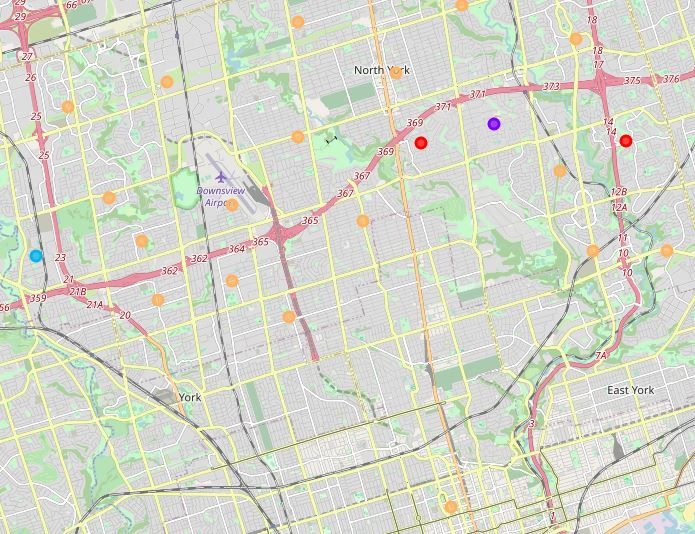

Here's Toronto subway map:

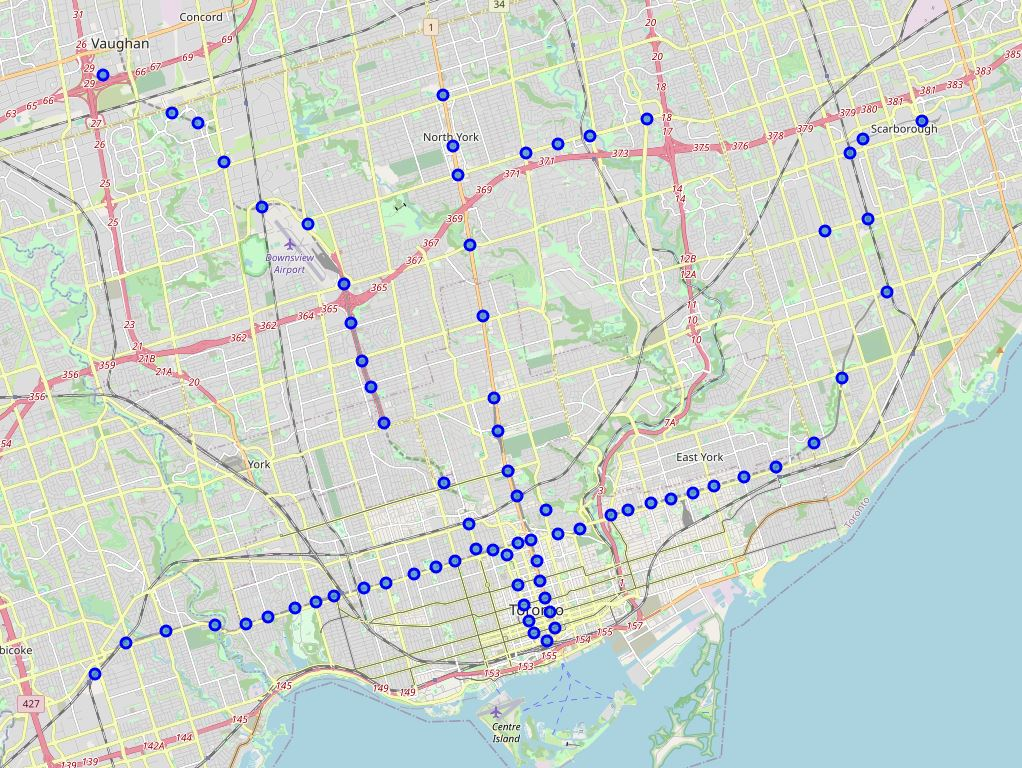

Next step we are going to find out what each neighborhood is like and find the common venue categories. Here we use Foursquare API to collect information we need: name of the neighborhoods, venues and venue categories.

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## One Hot Encoding

Now we are trying to find out what are the different kinds of venue categories present in each neighbourhood and calculate the top 10 common venues.

Since those venue categories are categorical datatype, we need to do one hot encoding to convert categorical data into numeric data. 

In [ ]:
#onehot encoding

NY_onehot = pd.get_dummies(NY_venues[['Venue Category']], prefix="", prefix_sep="")

NY_onehot['Neighborhood'] = NY_venues['Neighborhood']

# move neighborhood column to the first column

ny_fixed_columns = [NY_onehot.columns[-1]] + list(NY_onehot.columns[:-1])

NY_onehot = NY_onehot[ny_fixed_columns]

In [ ]:
NY_grouped = NY_onehot.groupby('Neighborhood').mean().reset_index()
NY_grouped.head()

,Neighborhood,Accessories Store,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Store,Bike Shop,Boutique,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Butcher,Café,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,...,Jewelry Store,Juice Bar,Liquor Store,Lounge,Luggage Store,Massage Studio,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Restaurant,Salon / Barbershop,Sandwich Place,Shoe Store,Shopping Mall,Spa,Sporting Goods Shop,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Thai Restaurant,Theater,Toy / Game Store,Trail,Video Game Store,Vietnamese Restaurant
0,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.083333,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.041667,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.083333,0.000000,0.0,0.0,0.0,0.000000,0.041667,0.0,0.000000,0.041667,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.041667,0.0,0.0,0.041667,0.0,0.041667,0.041667,0.0,0.0,0.0,0.000000,0.0,0.0,0.041667,0.0,0.041667,0.0,0.041667,0.0,0.000000,0.0,0.041667,0.0,0.041667,0.000000,0.0,0.0,0.0,0.0,0.0
1,Bayview Village,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.250000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.250000,0.000000,0.250000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,"Bedford Park, Lawrence Manor East",0.0,0.000000,0.041667,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.041667,0.041667,0.000000,0.000000,0.0,0.000000,0.083333,0.041667,0.0,0.0,0.0,0.041667,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.041667,0.041667,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.041667,0.041667,0.0,0.0,0.0,0.041667,0.0,0.0,0.041667,0.0,0.083333,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.041667,0.041667,0.0,0.0,0.0,0.0,0.0
3,Don Mills,0.0,0.000000,0.000000,0.041667,0.0,0.041667,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.083333,0.041667,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.041667,0.041667,0.041667,0.0,0.041667,0.083333,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.041667,0.000000,0.041667,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.083333,0.0,0.041667,0.0,0.000000,0.0,0.041667,0.0,0.041667,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,Downsview,0.0,0.071429,0.000000,0.000000,0.0,0.000000,0.071429,0.0,0.071429,0.0,0.071429,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.071429,0.0,0.0,...,0.0,0.000000,0.071429,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.142857,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.071429,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


### Venues in Neighborhood

Since we have finished encoding, we are going to define a function to find most common venues for a neighborhood.

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Getting the top venue categories in the neighbourhoods of North York

In [ ]:
neighborhoods_venues_sorted_NY.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Sandwich Place,Middle Eastern Restaurant,Mobile Phone Shop,Intersection,Park,Ice Cream Shop,Pharmacy,Pizza Place
1,Bayview Village,Japanese Restaurant,Chinese Restaurant,Café,Bank,Dog Run,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store
2,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Sandwich Place,Greek Restaurant,Pub,Fast Food Restaurant,Grocery Store,Hobby Shop,Indian Restaurant,Cupcake Shop
3,Don Mills,Gym,Restaurant,Coffee Shop,Japanese Restaurant,Beer Store,Sandwich Place,Clothing Store,Chinese Restaurant,Café,Dim Sum Restaurant
4,Downsview,Grocery Store,Park,Bank,Airport,Liquor Store,Food Truck,Athletics & Sports,Gym / Fitness Center,Discount Store,Baseball Field


## K-Means Clustering

Now it's time to build our clustering model. Let's set k=5 for start.

In [ ]:
kclusters = 5

NY_grouped_clustering = NY_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NY_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

Do clustering and plot results. The result looks like this:

In [ ]:
NY_merged = df_ny

# merge two datasets to add latitude/longitude for each neighborhood
NY_merged = NY_merged.join(neighborhoods_venues_sorted_NY.set_index('Neighborhood'), on='Neighbourhood')

NY_merged.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0.0,Park,Food & Drink Shop,Discount Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega
1,M4A,North York,Victoria Village,43.725882,-79.315572,4.0,Coffee Shop,Pizza Place,Hockey Arena,Portuguese Restaurant,Discount Store,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,4.0,Clothing Store,Furniture / Home Store,Vietnamese Restaurant,Miscellaneous Shop,Boutique,Coffee Shop,Event Space,Accessories Store,Supermarket,Dim Sum Restaurant
7,M3B,North York,Don Mills,43.745906,-79.352188,4.0,Gym,Restaurant,Coffee Shop,Japanese Restaurant,Beer Store,Sandwich Place,Clothing Store,Chinese Restaurant,Café,Dim Sum Restaurant
10,M6B,North York,Glencairn,43.709577,-79.445073,4.0,Park,Japanese Restaurant,Pizza Place,Asian Restaurant,Bakery,Pub,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop


## Project goal: Find a Satisfying Neighborhood

We have finished data cleaning, visualization and clustering, now it's time to solve the problems this project aims at.

Imagine a person (I will use my information to build an example) lives in downtown Toronto and he wants to move to North York, he needs a guide to select the best neighborhood for him and then locate a condo or house around the chosen area. Here are some brief information about this guy:

1.He's now living in Queen's Park area.

2.He's asian. He loves asian food and coffee.

3.He wants to live in a safe neighborhood.

4.He needs to take a subway everyday.

Now we will do our job to help this guy locate his future.

### Clustering

The first step we gonna do is clustering. This time, we will add his previous address 'Queen's Park' to the 'North York' data set and do clustering again, our goal is to find a cluster that has similar features.

Of course, we need to do one hot coding again for 'Queen's Park' Neighborhood. Skip these similas steps and we plot the clusters in a map.

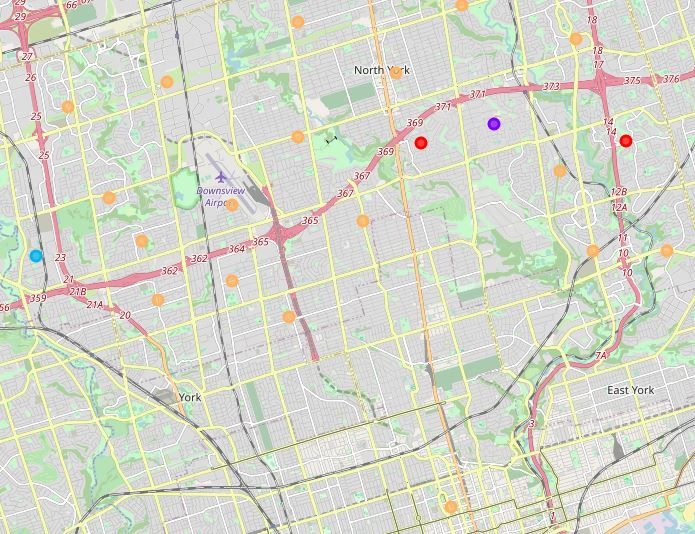

As we can see above, Queen's Park neighborhood is in cluster 0. It's a big cluster so only a few neighborhoods are filtered out. Since the clustering result is not that feasible, we need to go deep into the venue data.

## Venue Analysis

Now we dive into the data and select neighborhoods that contains keywords for the customer.

First, we take a glance at venues in Queen's Park neighborhood.

In [ ]:
NY_merged_plus[NY_merged_plus['Neighbourhood'].str.contains('Provincial')]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,4.0,Coffee Shop,Sushi Restaurant,Yoga Studio,Beer Bar,Gym,Distribution Center,Diner,Italian Restaurant,Japanese Restaurant,Creperie


It's clear that there are a lot of coffee shop and asian restaurant in this neighborhood. Mexican restaurants are common, too. Next, let's do a research in North York neighborhoods, we are gonna find those neighborhoods that has coffee shop and asian/mexico restaurants in its top 5 venues. So, we select those neighborhoods that has these kinds of venues in its top5 list.

In [ ]:
NY_chosen = NY_merged_plus.iloc[[2,3,8,9,10,17,19]]
NY_chosen.reset_index(drop = True,inplace = True)
NY_chosen

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,4.0,Clothing Store,Furniture / Home Store,Boutique,Event Space,Miscellaneous Shop,Coffee Shop,Accessories Store,Vietnamese Restaurant,Bakery,Convenience Store
1,M3B,North York,Don Mills,43.745906,-79.352188,4.0,Gym,Beer Store,Coffee Shop,Japanese Restaurant,Restaurant,Sandwich Place,Clothing Store,Caribbean Restaurant,Café,Dim Sum Restaurant
2,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,4.0,Clothing Store,Coffee Shop,Fast Food Restaurant,Japanese Restaurant,Cosmetics Shop,Restaurant,Juice Bar,Shoe Store,Bakery,Bank
3,M3J,North York,"Northwood Park, York University",43.767980,-79.487262,4.0,Coffee Shop,Bar,Vietnamese Restaurant,Massage Studio,Metro Station,Miscellaneous Shop,Caribbean Restaurant,Furniture / Home Store,Bakery,Bank
4,M2K,North York,Bayview Village,43.786947,-79.385975,4.0,Chinese Restaurant,Café,Bank,Japanese Restaurant,Yoga Studio,Discount Store,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie
5,M5M,North York,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,4.0,Sandwich Place,Coffee Shop,Italian Restaurant,Liquor Store,Pub,Pizza Place,Pharmacy,Butcher,Comfort Food Restaurant,Greek Restaurant
6,M2N,North York,"Willowdale, Willowdale East",43.770120,-79.408493,4.0,Ramen Restaurant,Sandwich Place,Coffee Shop,Café,Pizza Place,Sushi Restaurant,Hotel,Plaza,Bubble Tea Shop,Pet Store


## Crime Rate Analysis

To do further ranking, we will use more data. Safety is important for a new comer, so in this section we will use crime rate data to do analysis. The crime rate data looks like this:

In [ ]:
crime_rate.head()

,OBJECTID,Neighbourhood,Hood_ID,Population,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,Assault_AVG,Assault_CHG,Assault_Rate_2019,AutoTheft_2014,AutoTheft_2015,AutoTheft_2016,AutoTheft_2017,AutoTheft_2018,AutoTheft_2019,AutoTheft_AVG,AutoTheft_CHG,AutoTheft_Rate_2019,BreakandEnter_2014,BreakandEnter_2015,BreakandEnter_2016,BreakandEnter_2017,BreakandEnter_2018,BreakandEnter_2019,BreakandEnter_AVG,BreakandEnter_CHG,BreakandEnter_Rate_2019,Homicide_2014,Homicide_2015,Homicide_2016,Homicide_2017,Homicide_2018,Homicide_2019,Homicide_AVG,Homicide_CHG,Homicide_Rate_2019,Robbery_2014,Robbery_2015,Robbery_2016,Robbery_2017,Robbery_2018,Robbery_2019,Robbery_AVG,Robbery_CHG,Robbery_Rate_2019,TheftOver_2014,TheftOver_2015,TheftOver_2016,TheftOver_2017,TheftOver_2018,TheftOver_2019,TheftOver_AVG,TheftOver_CHG,TheftOver_Rate_2019,Shape__Area,Shape__Length
0,1,Yonge-St.Clair,97,12528,20,29,39,27,34,37,31.0,0.09,295.3,2,3,7,2,6,6,4.3,0.00,47.9,37,20,12,19,24,28,23.3,0.17,223.5,0,0,0,0,0,0,0.0,0.0,0.0,6,5,6,8,5,4,5.7,-0.20,31.9,4,5,8,0,3,6,4.3,1.00,47.9,1.161315e+06,5873.270582
1,2,York University Heights,27,27593,271,296,361,344,357,370,333.2,0.04,1340.9,105,100,105,92,92,144,106.3,0.57,521.9,107,139,98,105,122,108,113.2,-0.11,391.4,1,0,2,1,1,0,0.8,-1.0,0.0,59,84,70,75,88,79,75.8,-0.10,286.3,30,46,37,39,38,28,36.3,-0.26,101.5,1.324666e+07,18504.777326
2,3,Lansing-Westgate,38,16164,44,80,68,85,75,72,70.7,-0.04,445.4,19,22,27,26,16,32,23.7,1.00,198.0,34,27,41,42,50,39,38.8,-0.22,241.3,0,0,0,0,10,0,1.7,-1.0,0.0,11,5,9,17,35,11,14.7,-0.69,68.1,4,5,5,11,6,11,7.0,0.83,68.1,5.346186e+06,11112.109625
3,4,Yorkdale-Glen Park,31,14804,106,136,174,161,175,209,160.2,0.19,1411.8,63,53,41,52,63,61,55.5,-0.03,412.1,51,57,66,58,64,84,63.3,0.31,567.4,1,1,1,1,2,1,1.2,-0.5,6.8,23,21,24,35,44,42,31.5,-0.05,283.7,23,14,26,23,20,29,22.5,0.45,195.9,6.038326e+06,10079.426920
4,5,Stonegate-Queensway,16,25051,88,71,76,95,87,82,83.2,-0.06,327.3,34,29,12,32,31,34,28.7,0.10,135.7,71,45,49,49,39,64,52.8,0.64,255.5,0,0,0,0,0,0,0.0,0.0,0.0,21,14,16,26,25,22,20.7,-0.12,87.8,7,8,4,6,7,4,6.0,-0.43,16.0,7.946202e+06,11853.189878


We choose the neighborhoods that are selected in the last section and calculate their average crime rate score.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Neighbourhood,Assault_Rate_2019,AutoTheft_Rate_2019,BreakandEnter_Rate_2019,Homicide_Rate_2019,Robbery_Rate_2019,TheftOver_Rate_2019,crime_rate_avg
1,York University Heights,1340.9,521.9,391.4,0.0,286.3,101.5,4.157715
3,Yorkdale-Glen Park,1411.8,412.1,567.4,6.8,283.7,195.9,5.675270
9,Danforth East York,483.1,52.4,139.7,0.0,34.9,40.7,1.018460
45,Bayview Woods-Steeles,342.1,136.8,152.0,7.6,38.0,15.2,1.982641
49,Old East York,498.2,43.3,140.8,0.0,86.6,32.5,1.152379
81,Englemount-Lawrence,518.5,102.8,147.5,0.0,71.5,31.3,1.233705
84,Banbury-Don Mills,267.2,151.7,292.5,0.0,36.1,50.6,1.379827
95,Willowdale East,333.1,113.0,174.5,0.0,79.3,47.6,1.279963
96,Willowdale West,661.3,183.0,124.0,0.0,165.3,59.0,1.916132
107,Parkwoods-Donalda,454.0,91.9,195.4,2.9,103.4,14.4,1.658286


From the form above we can figure out some important news:

York University neighborhood is dangerous, do not move to that area!

For the rest, Fairview, Lawrence, Don Mills are great. Bayview and Willowdale are not that good but acceptable.

Note:Fairview neighborhood is called Don Valley Village in this data set

## Traffic Analysis

Since the customer needs to take a subway, let's calculate the distance between those neighborhoods and the closest subway station around it. In this section we will scrap subway station data from wikipedia.

,Station,Latitude,Longitude
0,Finch,43.781297,-79.415899
1,North York Centre,43.768679,-79.412630
2,Sheppard–Yonge,43.761452,-79.410915
3,York Mills,43.744039,-79.406657
4,Lawrence,43.726348,-79.402474


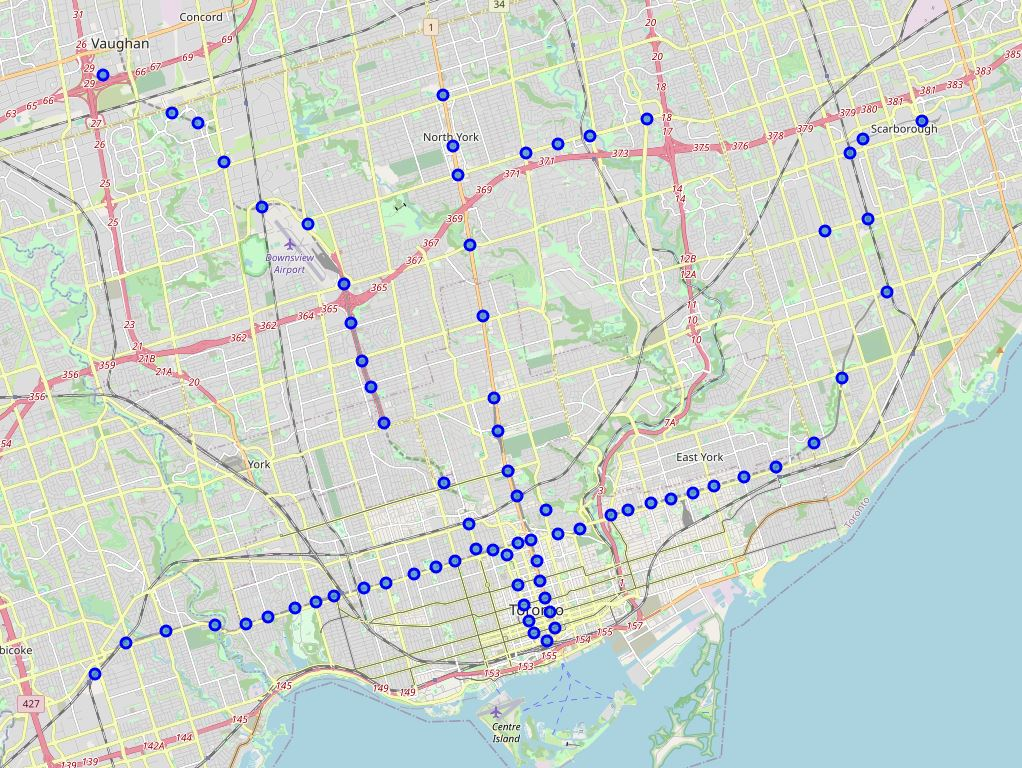

Create a dataframe to collect neighborhood;s position, latitude, longitude, closest subway station and distance(kilometer).

,Neighborhood,Latitude,Longitude,Closest,Distance
0,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Yorkdale,0.962
1,Don Mills,43.745906,-79.352188,Leslie,1.863
2,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,Don Mills,0.221
3,"Northwood Park, York University",43.767980,-79.487262,Finch West,0.305
4,Bayview Village,43.786947,-79.385975,Bessarion,1.317
5,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,Lawrence,0.989
6,"Willowdale, Willowdale East",43.770120,-79.408493,North York Centre,0.230


Willowdale, Fairview and York University are close to subway station. Lawrence, Don mills, Bayview Village and Lawrence are not good enough, the distance is more than 1km.

## Result and Conclusion

According to the analysis, York University neighborhood is not safe so we will not consider this place. For the rest candidates, Fairview neighborhood is close to subway station and it's safe according to the record. Willwodale is the second choice, it is also close to the subway station, but the west part of Willowdale is not that safe. Don Mills, Bayview Village and Lawrence are too fart from subway station so they are not that good. In general, Fairview neighborhood is the best choice.

This project helps a person get a better understanding of the neighborhoods with respect to venues, crime rates and other data in that neighborhood. This project shows how data analysis helps people live better. Further discussion may include taking other factors such as quality of education, supermarkets, highways, cost of living, house price and so on.